In [1]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

In [2]:
paths = glob(os.path.expanduser('~/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/*.jsonl'))
paths

['/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job5_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job4_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job2_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job7_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job1_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job6_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job3_results.jsonl',
 '/home/matt/PycharmProjects/benchmarking_test/results_readwrite_keyvalue/job0_results.jsonl']

In [3]:
duration_seconds = 60
op_cols = ['put', 'delete', 'get']
found_cols = ['get_found', 'delete_found']
constant_cols = ['leaf_capacity', 'parent_capacity', 'vacuum_threshold', 'key_length']

entries_by_type = defaultdict(list)
for path in paths:
    with open(path, 'rt') as fp:
        for line in fp:
            spec, counts = json.loads(line)
            spec.update(counts)
            entries_by_type[spec.pop('type')].append(spec)


def clean_results(tp, entries):
    results = pd.DataFrame(entries)
    results['type'] = tp

    results = results.rename(columns={
        'deleteFound': 'delete_found',
        'getFound': 'get_found'
    })
    
    results = results[results['seconds'] == duration_seconds].drop('seconds', axis=1)
    
    
    #results['min_vacuum_size'] = (results['min_vacuum_size'] / 1e6).astype(int)    
    #for col in constant_cols:
    #    assert results[col].nunique() == 1, f'{col} is not constant'
    #results = results.drop(constant_cols, axis=1)

    return results


results = pd.concat([clean_results(tp, entries) for tp,entries in entries_by_type.items()])
print(len(results))
results.sample(5).T

2238


,970,312,135,565,162
key_length,16,16,16,16,16
value_length,256,256,256,4096,4096
put_del_get,DELETE_HEAVY,BALANCED,BALANCED,BALANCED,GET_HEAVY
known_key_rate,0.5,0.5,0.5,0.5,0.5
thread_count,4,1,4,64,16
trial_index,9,5,2,4,6
pending_write_merge_threshold,1e+06,NaN,1e+06,NaN,1e+06
base_index_rate,10,NaN,10,NaN,10
put,3873618,23348,1743338,27104,367499
delete,3874637,23153,1745763,27235,183153


In [4]:
index_cols = [c for c in results.columns if c not in (op_cols + found_cols + ['trial_index'])]
x = results.copy()
for col in op_cols:
    x[col] = (x[col] / duration_seconds / 1000).round(2).astype(float)
x['sum'] = x[op_cols].sum(axis=1).round(2)

norm_agg = {}
for tp in x['type'].unique():
    y = x[x['type'] == tp].T.dropna().T
    for col in op_cols + ['sum']:
        y[col] = y[col].astype(float)
    y = y.groupby([c for c in index_cols if c in y.columns])[op_cols + ['sum']].describe()
    display(y.sample(5))
    norm_agg[tp] = y

put  \
                                                                                                                    count   
key_length value_length put_del_get  known_key_rate thread_count pending_write_merge_threshold base_index_rate type         
16         4096         BALANCED     0.5            1            100000.0                      10.0            lsm    5.0   
           256          BALANCED     0.9            1            1000000.0                     10.0            lsm    7.0   
                        DELETE_HEAVY 0.9            64           1000000.0                     10.0            lsm    5.0   
           4096         BALANCED     0.5            16           1000000.0                     10.0            lsm    6.0   
                        DELETE_HEAVY 0.1            4            1000000.0                     10.0            lsm    6.0   

                                                                                                                                \
                                                                                                                          mean   
key_length value_length put_del_get  known_key_rate thread_count pending_write_merge_threshold base_index_rate type              
16         4096         BALANCED     0.5            1            100000.0                      10.0            lsm   11.600000   
           256          BALANCED     0.9            1            1000000.0                     10.0            lsm   84.942857   
                        DELETE_HEAVY 0.9            64           1000000.0                     10.0            lsm   58.444000   
           4096         BALANCED     0.5            16           1000000.0                     10.0            lsm   21.573333   
                        DELETE_HEAVY 0.1            4            1000000.0                     10.0            lsm   30.885000   

                                                                                                                               \
                                                                                                                          std   
key_length value_length put_del_get  known_key_rate thread_count pending_write_merge_threshold base_index_rate type             
16         4096         BALANCED     0.5            1            100000.0                      10.0            lsm   0.506113   
           256          BALANCED     0.9            1            1000000.0                     10.0            lsm   4.021072   
                        DELETE_HEAVY 0.9            64           1000000.0                     10.0            lsm   2.966805   
           4096         BALANCED     0.5            16           1000000.0                     10.0            lsm   0.420793   
                        DELETE_HEAVY 0.1            4            1000000.0                     10.0            lsm   2.156486   

                                                                                                                            \
                                                                                                                       min   
key_length value_length put_del_get  known_key_rate thread_count pending_write_merge_threshold base_index_rate type          
16         4096         BALANCED     0.5            1            100000.0                      10.0            lsm   11.23   
           256          BALANCED     0.9            1            1000000.0                     10.0            lsm   77.31   
                        DELETE_HEAVY 0.9            64           1000000.0                     10.0            lsm   56.32   
           4096         BALANCED     0.5            16           1000000.0                     10.0            lsm   21.07   
                        DELETE_HEAVY 0.1            4            1000000.0                     10.0            lsm   29.03   

                                  

put  \
                                                                                                                                     count   
key_length value_length put_del_get known_key_rate thread_count type  leaf_capacity parent_capacity vacuum_threshold min_vacuum_size         
16         4096         PUT_HEAVY   0.5            16           btree 8.0           16.0            0.8              10000000.0        7.0   
                        GET_HEAVY   0.1            64           btree 8.0           16.0            0.8              10000000.0        5.0   
                        BALANCED    0.9            64           btree 8.0           16.0            0.8              10000000.0        6.0   
                        PUT_HEAVY   0.5            4            btree 8.0           16.0            0.8              10000000.0        4.0   
                        BALANCED    0.1            16           btree 8.0           16.0            0.8              10000000.0        3.0   

                                                                                                                                                \
                                                                                                                                          mean   
key_length value_length put_del_get known_key_rate thread_count type  leaf_capacity parent_capacity vacuum_threshold min_vacuum_size             
16         4096         PUT_HEAVY   0.5            16           btree 8.0           16.0            0.8              10000000.0       0.608571   
                        GET_HEAVY   0.1            64           btree 8.0           16.0            0.8              10000000.0       0.540000   
                        BALANCED    0.9            64           btree 8.0           16.0            0.8              10000000.0       0.428333   
                        PUT_HEAVY   0.5            4            btree 8.0           16.0            0.8              10000000.0       0.587500   
                        BALANCED    0.1            16           btree 8.0           16.0            0.8              10000000.0       0.556667   

                                                                                                                                                \
                                                                                                                                           std   
key_length value_length put_del_get known_key_rate thread_count type  leaf_capacity parent_capacity vacuum_threshold min_vacuum_size             
16         4096         PUT_HEAVY   0.5            16           btree 8.0           16.0            0.8              10000000.0       0.012150   
                        GET_HEAVY   0.1            64           btree 8.0           16.0            0.8              10000000.0       0.007071   
                        BALANCED    0.9            64           btree 8.0           16.0            0.8              10000000.0       0.016021   
                        PUT_HEAVY   0.5            4            btree 8.0           16.0            0.8              10000000.0       0.012583   
                        BALANCED    0.1            16           btree 8.0           16.0            0.8              10000000.0       0.015275   

                                                                                                                                            \
                                                                                                                                       min   
key_length value_length put_del_get known_key_rate thread_count type  leaf_capacity parent_capacity vacuum_threshold min_vacuum_size         
16         4096         PUT_HEAVY   0.5            16           btree 8.0           16.0            0.8              10000000.0       0.59   
                        GET_HEAVY   0.1            64           btree 8.0           16.0    

In [5]:
agg_median = {tp:pd.concat([x[col]['50%'].rename(col) for col in op_cols + ['sum']], axis=1)
              for tp,x in norm_agg.items()}

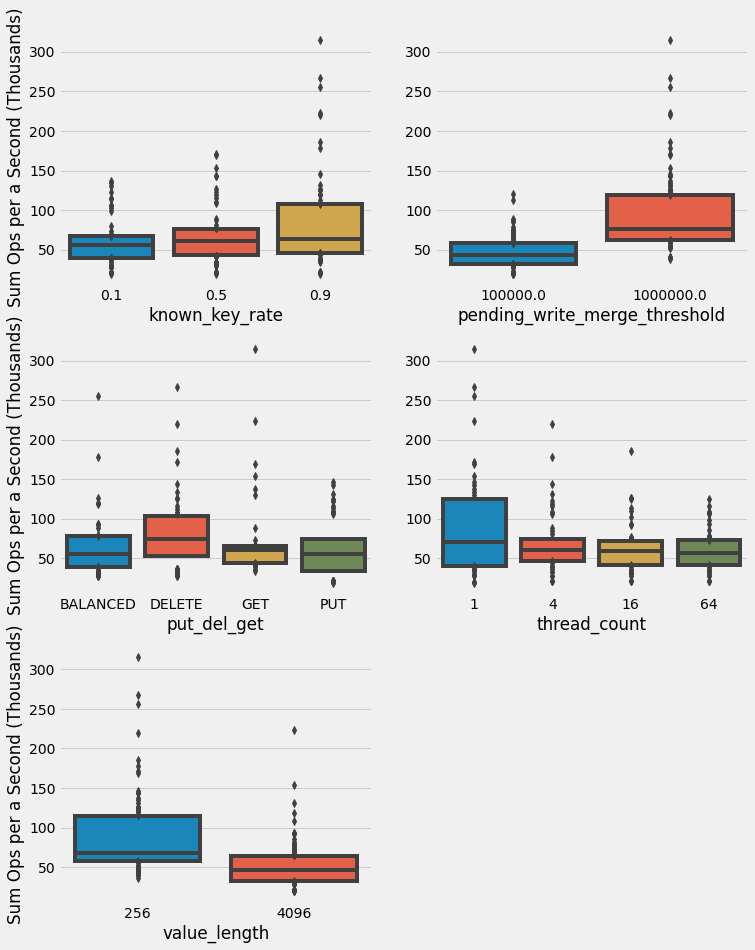

In [6]:
fig = plt.figure(figsize=(11,15))
x = norm_agg['lsm']['sum'].copy()
cols = sorted(set(x.index.names) -
              {'key_length', 'type', 'parent_capacity', 'leaf_capacity', 'vacuum_threshold', 'base_index_rate'})
x = x.reset_index()
x['put_del_get'] = x['put_del_get'].str.replace('_HEAVY', '')
for i,col in enumerate(cols):
    ax = fig.add_subplot(3, 2, i + 1)
    sns.boxplot(ax=ax, x=col, y="50%",
                  data=x,
                  whis=0)
    #plt.ylim(-0.5, 6.5)
    plt.ylabel('Sum Ops per a Second (Thousands)' if i%2==0 else '')

In [7]:
x = norm_agg['lsm']['get'].reset_index()
x = x[x['put_del_get'] == 'GET_HEAVY']
x.sort_values('50%', ascending=False)

,key_length,value_length,put_del_get,known_key_rate,thread_count,pending_write_merge_threshold,base_index_rate,type,count,mean,std,min,25%,50%,75%,max
65,16,256,GET_HEAVY,0.9,1,1000000.0,10.0,lsm,9.0,266.412222,2.356007,262.84,264.9400,267.960,268.1700,268.63
161,16,4096,GET_HEAVY,0.9,1,1000000.0,10.0,lsm,7.0,188.905714,1.828295,186.32,187.4000,189.750,190.4200,190.63
57,16,256,GET_HEAVY,0.5,1,1000000.0,10.0,lsm,5.0,143.954000,0.449088,143.24,143.9000,144.000,144.1900,144.44
153,16,4096,GET_HEAVY,0.5,1,1000000.0,10.0,lsm,4.0,130.712500,1.396433,129.11,130.0100,130.640,131.3425,132.46
49,16,256,GET_HEAVY,0.1,1,1000000.0,10.0,lsm,4.0,116.612500,0.315951,116.20,116.4475,116.695,116.8600,116.86
145,16,4096,GET_HEAVY,0.1,1,1000000.0,10.0,lsm,8.0,110.661250,0.647577,109.28,110.4300,110.880,110.9475,111.46
64,16,256,GET_HEAVY,0.9,1,100000.0,10.0,lsm,3.0,74.940000,0.141067,74.81,74.8650,74.920,75.0050,75.09
160,16,4096,GET_HEAVY,0.9,1,100000.0,10.0,lsm,6.0,61.951667,0.885650,60.55,61.4225,62.315,62.5925,62.72
51,16,256,GET_HEAVY,0.1,4,1000000.0,10.0,lsm,4.0,56.610000,0.968745,55.46,56.0750,56.625,57.1600,57.73
59,16,256,GET_HEAVY,0.5,4,1000000.0,10.0,lsm,7.0,56.150000,0.799833,54.99,55.5750,56.400,56.6350,57.24


In [8]:
x = {"put":3138426,
     "delete":1569044,
     "deleteFound":1569044,
     "get":26684492,
     "getFound":911581}
pd.Series(x)[op_cols] / 60 / 1000

put        52.307100
delete     26.150733
get       444.741533
dtype: float64

In [9]:
time=625.0 
x = {"put":12555521,"delete":6279984,"deleteFound":6279984,"get":106749502,"getFound":1148989}
pd.Series(x)[op_cols] / time / 1000

put        20.088834
delete     10.047974
get       170.799203
dtype: float64